# Adaptive linear neurons (Adaline) with gradient descent and stochastic gradient descent

The key difference between the Adaline rule and perceptron is that the weights are updated based on a linear
activation function rather than a unit step function like in the perceptron. We define the cost function J to learn the weights as the Sum of Squared Errors (SSE) between the calculated outcome and the true class label. We then use gradient descent to find the weights that minimize our cost function to classify the samples in the dataset.

Although the Adaline learning rule looks identical to the perceptron rule, the z = wTx is a real number and not an integer class label. The gradient and weight update is calculated based on all samples in the training set (instead of
updating the weights incrementally after each sample), which is call batch gradient descent. We minimize a cost function by taking a step into the opposite direction of a gradient that is calculated from the whole training set.

A popular alternative to the batch gradient descent algorithm is stochastic gradient descent, sometimes also called iterative or on-line gradient descent. Instead of updating the weights based on the sum of the accumulated errors over all samples, we update the weights incrementally for each training sample. SGD can escape shallow local minima more
readily and can be used for online learning.

A compromise between batch gradient descent and stochastic gradient descent is the so-called mini-batch learning. Convergence is reached faster via mini-batches because of the more frequent weight updates. allows us to replace the for-loop over the training samples in SGD by vectorized operations, which can further improve the computational efficiency of our learning algorithm.

#### Implementing GD adaline learning

In [2]:
import numpy as np

class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        SSE in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
    
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(X.shape[1] + 1)
        self.cost_ = []
        
        for i in range(self.n_iter):
            # calculating wTx
            output = self.net_input(X)

            # calculating errors
            errors = y - output
            
            # calculating weight update
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # calculating cost
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
        # Please note that the "activation" method has no effect
        # in the code since it is simply an identity function. We
        # could write `output = self.net_input(X)` directly instead.
        # The purpose of the activation is more conceptual, i.e.,  
        # in the case of logistic regression, we could change it to
        # a sigmoid function to implement a logistic regression classifier.
        
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)
    
    
        

#### Implementing SGD adaline learning

In [8]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        average cost in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.

    """
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
    
    def _initialize_weights(self, m):
        """ use a _initialize_weights method to initialize weights to zero 
            and after initialization set w_initialized to True """
        self.w_ = np.zeros(m + 1)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        """This method perform one weight update for one training sample xi and calculate the error
        Since weights update will be used is both fit and partial fit methods, 
        it's better to seperate it out to be concise"""
        output = self.net_input(xi)
        error = target - output
        self.w_[0] += self.eta * error
        self.w_[1:] += self.eta * xi.dot(error)
        cost = 0.5 * error ** 2
        return cost
    
    def _shuffle(self, X, y):
        """Shuffle training data with np random permutation"""
        seq = np.random.permutation(len(y))
        return X[seq], y[seq]
    
    def fit(self, X, y):
        
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
        
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)
    

In [10]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('r', 'b', 'g', 'k', 'grey')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision regions by creating a pair of grid arrays xx1 and xx2 via meshgrid function in Numpy
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    # use predict method to predict the class labels z of the grid points
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    # draw the contour using matplotlib
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for i, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1], alpha=0.8, c=cmap(i), marker=markers[i], label=cl)

#### Training the AdalineSGD model on the Iris dataset

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# read in iris data
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)

# select two classes: setosa and versicolor
y = df.iloc[0:100, 4].values  # values method of a pandas dataframe yields Numpy array
y = np.where(y == 'Iris-setosa', -1, 1)

# select two features: sepal length and petal length for visualization
X = df.iloc[0:100, [0,2]].values

# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

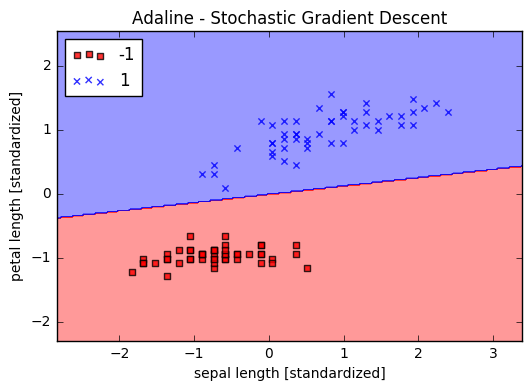

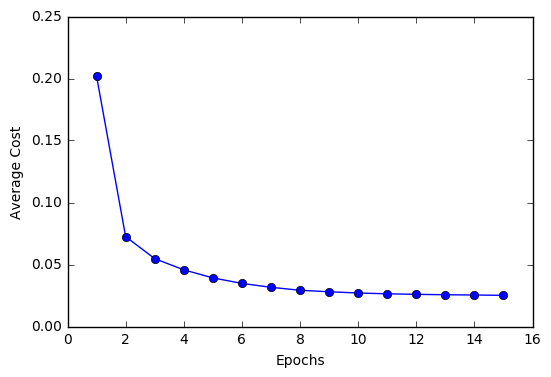

In [12]:
adasgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
adasgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=adasgd)

plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(adasgd.cost_) + 1), adasgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()